# MTA Subway Ridership Data Analysis

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/MTA_New_York_City_Subway_logo.svg/2560px-MTA_New_York_City_Subway_logo.svg.png">

### Understaning the dataset

This data set is provided by the Metropolitan Transportation Authority via the [NYC Open Data](https://data.ny.gov/) platform. The ridership metrics provided may differ slightly, but are within 1% of
ridership figures provided at public MTA board meetings. Data is released weekly. The latest version of the datset can be found [here](https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-Beginning-February-202/wujg-7c2s).

Below you can find a data dictionary for the dataset:

| Column Name | Data Type | Purpose |
|---------|--------|--------|
|transit_timestamp| Plain Text|Timestamp payment took place in local time. All transactions here are rounded down to the nearest hour. For example, a swipe that took place at 1:37pm will be reported as having taken place at 1pm.|
|station_complex_id| Plain Text| A unique identifier for station complexes|
|station_complex| Plain Text| The subway complex where an entry swipe or tap took place. Large subway complexes, such as Times Square and Fulton Center, may contain multiple subway lines.|
|routes| Plain Text| Refers to the different subway routes that stop at a particular subway station.|
|borough| Plain Text| Represents one of the boroughs of New York City serviced by the subway system (Bronx, Brooklyn, Manhattan, Queens).|
|payment_method| Plain Text| Specifies whether the payment method used to enter was from OMNY or MetroCard. The value all is temporarily being used while this data is being made available.|
|ridership| int64| Total number of riders that entered a subway complex via OMNY or MetroCard at the specific hour.|
|transfers| int64| Number of individuals who entered a subway complex via a free bus-to-subway, or free out-of-network transfer. This represents a subset of total ridership, meaning that these transfers are already included in the preceding ridership column. Transfers that take place within a subway complex (e.g., individuals transferring from the 2 to the 4 train within Atlantic Avenue) are not captured here.|
|latitude| float64| Latitude for specified subway complex|
|longitude| float64| Longitude for the specified subway complex|
|Georeference| Point| Open Data platform-generated geocoding information from supplied address components. Point-type location is the centroid of the address components provided and does not reflect a specific address if the street address component is not provided. Point-type location is supplied in "POINT (<geocoded longitude> <geocoded latitude>)" format.|

The most necessary columns for our analysis are the following:
- transit_timestamp (to identify the time of day)
- station_complex (to identify the station)
- ridership (to identify the number of people entering the station at a given time)
- latitude / longitude / Georeference (to identify the location of the station)

### Potential Goals of Analysis

* What is the best time to schedule maintenance?
    - Which factors are most important to ridership (time of day, day of week, etc.)?
* Which part of the city has the most riders?
    - Which Borough?
* Which station sees the most riders?
* Does Subway usage have seasonal trends?
* Is there potential to build a model to predict ridership?

Overall by answering these questions and gaining a further understanding of ridership, it should highlight that the MTA could use data to improve crowd management, service performance and maintenance scheduling. 

### Outline
1. [Importing Libraries](###1.-importing-the-required-libraries)
2. [Data Preperation](###-2.-Preparing-the-data)
3. [Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
4. [Geographical Visualization](#4.-Geographical-Visualization)
5. [Predicting Ridership](#5.-Predicting-Ridership)
6. [Conclusion](###6.-Conclusion)

_____

### 1. Importing the required libraries

In [1]:
import pandas as pd # for data manipulation and analysis
import numpy as np

import seaborn as sns # for data visualization
import matplotlib.pyplot as plt
import plotly.express as px

import dash # for building interactive visualizations
from dash import dcc, html, Input, Output

import geopandas as gpd # for geographic data manipulation
from shapely.geometry import Point, Polygon

from sklearn.model_selection import train_test_split # for machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

________

### 2. Preparing the data

#### Read CSV to Dataframe

In [2]:
# read csv file to pd dataframe
df = pd.read_csv('MTA_Subway_Hourly_Ridership__Beginning_February_2022.csv')

View first 5 rows of the dataset to confirm the data is read properly

In [3]:
df.head()

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference
0,06/05/2022 04:00:00 AM,R639,"Church Av (2,5)",BK,"2,5",all,21,0,40.650845,-73.94958,POINT (-73.94958 40.650845)
1,06/21/2022 03:00:00 AM,R639,"Church Av (2,5)",BK,"2,5",all,24,0,40.650845,-73.94958,POINT (-73.94958 40.650845)
2,07/05/2022 03:00:00 AM,R639,"Church Av (2,5)",BK,"2,5",all,23,0,40.650845,-73.94958,POINT (-73.94958 40.650845)
3,07/07/2022 03:00:00 AM,R639,"Church Av (2,5)",BK,"2,5",all,18,0,40.650845,-73.94958,POINT (-73.94958 40.650845)
4,07/23/2022 01:00:00 AM,R639,"Church Av (2,5)",BK,"2,5",all,12,0,40.650845,-73.94958,POINT (-73.94958 40.650845)


In [4]:
# list the data types of the dataframe
df.dtypes

transit_timestamp      object
station_complex_id     object
station_complex        object
borough                object
routes                 object
payment_method         object
ridership               int64
transfers               int64
latitude              float64
longitude             float64
Georeference           object
dtype: object

#### Preparing the data for datetime format

In [5]:
# change transit_timestamp to datetime object
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])

Make a copy before slicing the dataset

In [6]:
original_df = df.copy()

#### Get data for one year

Since the data begins on February 1st 2022 we will use the data from Feb. 2022 &rarr; Feb. 2023. This will allow us to have an even distribution and outliers such as holiday will only occur once in the data.

In [7]:
# Filter data for the specified time range
start_date = pd.Timestamp('2022-02-01')
end_date = pd.Timestamp('2023-02-01')
df = df[(df.transit_timestamp >= start_date) & (df.transit_timestamp < end_date)]

In [8]:
# check the earliest and latest time of the data
print(df['transit_timestamp'].min())
print(df['transit_timestamp'].max())

2022-02-01 00:00:00
2023-01-31 23:00:00


#### Find the total number of rows

In [9]:
df.shape

(3634357, 11)

#### Find the number of null values

In [10]:
# total number of null values by column
df.isnull().sum()

transit_timestamp     0
station_complex_id    0
station_complex       0
borough               0
routes                0
payment_method        0
ridership             0
transfers             0
latitude              0
longitude             0
Georeference          0
dtype: int64

#### Clean the names of the stations by removing the route numbers

In [11]:
## remove the () and everything in between the () from each station_complex row in the df
df['station_complex'] = df['station_complex'].str.replace(r'\(.*\)', '', regex=True)

In [12]:
df

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference
0,2022-06-05 04:00:00,R639,Church Av,BK,"2,5",all,21,0,40.650845,-73.94958,POINT (-73.94958 40.650845)
1,2022-06-21 03:00:00,R639,Church Av,BK,"2,5",all,24,0,40.650845,-73.94958,POINT (-73.94958 40.650845)
2,2022-07-05 03:00:00,R639,Church Av,BK,"2,5",all,23,0,40.650845,-73.94958,POINT (-73.94958 40.650845)
3,2022-07-07 03:00:00,R639,Church Av,BK,"2,5",all,18,0,40.650845,-73.94958,POINT (-73.94958 40.650845)
4,2022-07-23 01:00:00,R639,Church Av,BK,"2,5",all,12,0,40.650845,-73.94958,POINT (-73.94958 40.650845)
...,...,...,...,...,...,...,...,...,...,...,...
5293792,2022-11-04 12:00:00,R419,Zerega Av,BX,6,all,74,1,40.836487,-73.84704,POINT (-73.84704 40.836487)
5293794,2022-10-07 21:00:00,R419,Zerega Av,BX,6,all,16,0,40.836487,-73.84704,POINT (-73.84704 40.836487)
5293795,2022-10-04 10:00:00,R419,Zerega Av,BX,6,all,85,1,40.836487,-73.84704,POINT (-73.84704 40.836487)
5293796,2022-03-13 17:00:00,R419,Zerega Av,BX,6,all,26,1,40.836487,-73.84704,POINT (-73.84704 40.836487)


Great! There are no null values in the dataset.

#### Preparing the data for geovisualization

In [13]:
# make geodataframe out of df
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

geo_stations_df = gdf.groupby(['station_complex_id', 'station_complex', 'borough', 'latitude','longitude', 'geometry'])['ridership'].sum().reset_index()

____

### 3. Exploratory Data Analysis

How many subway stations in our dataset?

In [14]:
# print the number of unique station complex ids
print(df['station_complex_id'].nunique())

423


Create a new dataframe grouped by station and ridership

In [15]:
by_station_df = df.groupby(['station_complex_id', 'station_complex', 'borough', 'latitude', 'longitude'])['ridership'].sum().reset_index()

by_station_df.shape

(423, 6)

In [16]:
by_station_df.head()

,station_complex_id,station_complex,borough,latitude,longitude,ridership
0,A002,Lexington Av,M,40.762660,-73.967255,10082907
1,A006,5 Av-59 St,M,40.764812,-73.973350,3065515
2,A010,57 St-7 Av,M,40.764664,-73.980660,6579806
3,A013,49 St,M,40.759900,-73.984140,4772207
4,A022,34 St-Herald Sq,M,40.749718,-73.987820,21372034


#### Riders by borough

In [17]:
## get the total ridership by borough
boroughs = df.groupby('borough')['ridership'].sum()
boroughs

borough
BK    237932586
BX     81994749
M     560176396
Q     156471936
Name: ridership, dtype: int64

#### Visualizing the amount of ridership by borough

In [18]:
fig = px.treemap(boroughs, path=[boroughs.index], values=boroughs.values, title='Subway Ridership by Borough')
fig.show()

We can see that Manhattan has the most ridership, followed by Brooklyn, Queens and the Bronx.

#### Visualizing the number of stations by Borough

In [19]:
station_count = by_station_df['borough'].value_counts()
borough_names = ['Brooklyn', 'Manhattan', 'Queens', 'Bronx']

fig = px.bar(x = borough_names, y = station_count.values, 
       color = station_count.index, text = station_count.values, 
       title = 'Number of Stations by Borough')

fig.update_layout( xaxis_title = "Boroughs", yaxis_title = "Subway Stations")
fig.show()

We can see that Manhattan actually has less stations despite having the most ridership.

Using a strip plot it allows us to see that each borough has a high concentration of stations with a low number of ridership. Each borough has a few stations with a much higher ridership than the rest, we can also see just how vast the difference is between the Times Sq-42 St station and the rest of the stations.

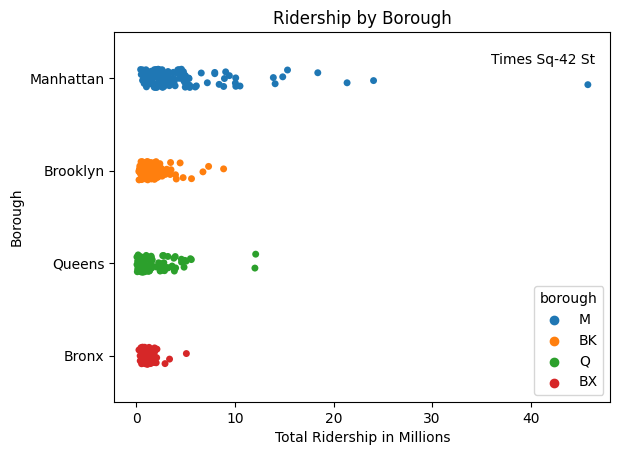

In [20]:
# make a copy of by_station_df and divide the ridership by 1 Million to normalize the data to millions
by_station_df_normalize = by_station_df.copy()
by_station_df_normalize['ridership'] = by_station_df_normalize['ridership']/1000000

sns.stripplot(x=by_station_df_normalize['ridership'], y=by_station_df_normalize['borough'], hue=by_station_df_normalize['borough'])
plt.yticks([0, 1, 2, 3], ['Manhattan', 'Brooklyn', 'Queens', 'Bronx']) 
plt.xlabel('Total Ridership in Millions')
plt.ylabel('Borough')
plt.annotate('Times Sq-42 St', xy=(0.76, 0.915), xycoords='axes fraction')
plt.title('Ridership by Borough')
plt.show()

#### Ridership by day of the week

In [21]:
## make a new column called day_of_week using the transit_timestamp column
df['day_of_week'] = df['transit_timestamp'].dt.day_name()

In [22]:
# Extract the date part from the datetime values and assign to a new column
df.loc[:, 'date_only'] = df['transit_timestamp'].dt.date

# Get the count of unique calendar days
unique_days_count = df['date_only'].nunique()

# Display the result
print("Count of unique calendar days:", unique_days_count)

Count of unique calendar days: 365


In [23]:
df.head()

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference,day_of_week,date_only
0,2022-06-05 04:00:00,R639,Church Av,BK,"2,5",all,21,0,40.650845,-73.94958,POINT (-73.94958 40.650845),Sunday,2022-06-05
1,2022-06-21 03:00:00,R639,Church Av,BK,"2,5",all,24,0,40.650845,-73.94958,POINT (-73.94958 40.650845),Tuesday,2022-06-21
2,2022-07-05 03:00:00,R639,Church Av,BK,"2,5",all,23,0,40.650845,-73.94958,POINT (-73.94958 40.650845),Tuesday,2022-07-05
3,2022-07-07 03:00:00,R639,Church Av,BK,"2,5",all,18,0,40.650845,-73.94958,POINT (-73.94958 40.650845),Thursday,2022-07-07
4,2022-07-23 01:00:00,R639,Church Av,BK,"2,5",all,12,0,40.650845,-73.94958,POINT (-73.94958 40.650845),Saturday,2022-07-23


In [24]:
by_day = df.groupby(['day_of_week'])['ridership'].sum().reset_index()

by_day.shape

(7, 2)

In [25]:
by_day

,day_of_week,ridership
0,Friday,165329907
1,Monday,150260511
2,Saturday,109755854
3,Sunday,86029635
4,Thursday,174458299
5,Tuesday,174848214
6,Wednesday,175893247


Reorder the dates by setting a list of days

In [26]:
lst = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
by_day["day_of_week"] = pd.Categorical(by_day["day_of_week"], categories=lst, ordered=True)

# Sort the DataFrame based on the custom order of the 'day_of_week' column
by_day = by_day.sort_values("day_of_week")

# Reset the index if needed
by_day = by_day.reset_index(drop=True)

In [27]:
by_day

,day_of_week,ridership
0,Monday,150260511
1,Tuesday,174848214
2,Wednesday,175893247
3,Thursday,174458299
4,Friday,165329907
5,Saturday,109755854
6,Sunday,86029635


Get the average ridership per day

In [28]:
by_day['ridership_per_day'] = by_day['ridership'] / 365


In [29]:
by_day

,day_of_week,ridership,ridership_per_day
0,Monday,150260511,411672.632877
1,Tuesday,174848214,479036.202740
2,Wednesday,175893247,481899.306849
3,Thursday,174458299,477967.942466
4,Friday,165329907,452958.649315
5,Saturday,109755854,300700.969863
6,Sunday,86029635,235697.630137


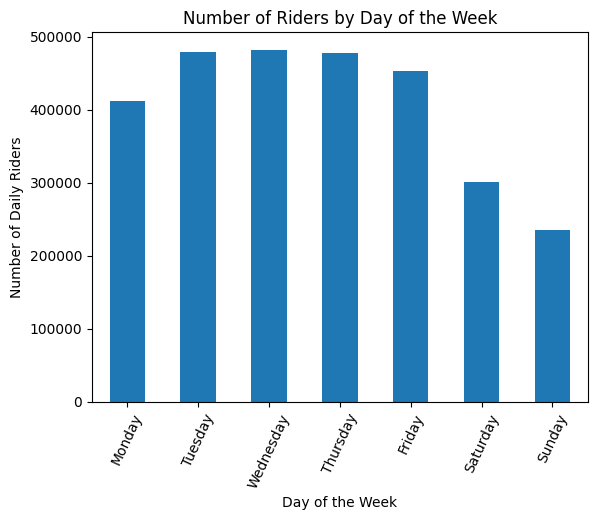

In [30]:
## plot just the ridership_per_day
by_day['ridership_per_day'].plot(kind='bar')
## name the plot
plt.title('Number of Riders by Day of the Week')
## label the x-axis with day_of_the_week
## change the x-axis to be the day of the week
## make xticks angled
plt.xlabel('Day of the Week')
plt.ylabel('Number of Daily Riders')
plt.xticks(rotation=45)
plt.xticks(range(7), lst, rotation=65)
plt.show()

We can see that the middle of the work week tends to have the highest number of riders, with a significant decrease on the weekends. We can create a similar visualization to see the ridership by month/

In [55]:
df.loc[:, 'month_only'] = df['transit_timestamp'].dt.month

by_month = df.groupby(['month_only'])['ridership'].sum().reset_index()
by_month['ridership_per_month'] = (by_month['ridership'] / 12).round().astype(int)
by_month.head()

,month_only,ridership,ridership_per_month
0,1,89433985,7452832
1,2,64580744,5381729
2,3,87630454,7302538
3,4,83623068,6968589
4,5,88044092,7337008


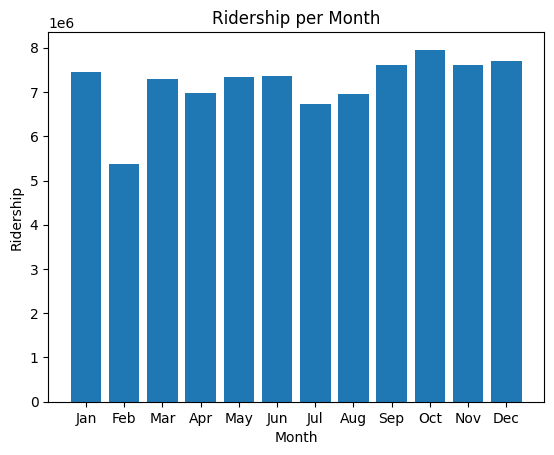

In [57]:
plt.bar(by_month['month_only'], by_month['ridership_per_month'])
plt.xlabel('Month')
plt.ylabel('Ridership')
plt.title('Ridership per Month')
plt.xticks(by_month['month_only'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec'])
plt.show()

We see a large decrease in february and a slight drop off during July and August. This is likely due to February only having 28 days and July and August being the summer months which would correlate with vacation frequency.

### Number of Riders by hour

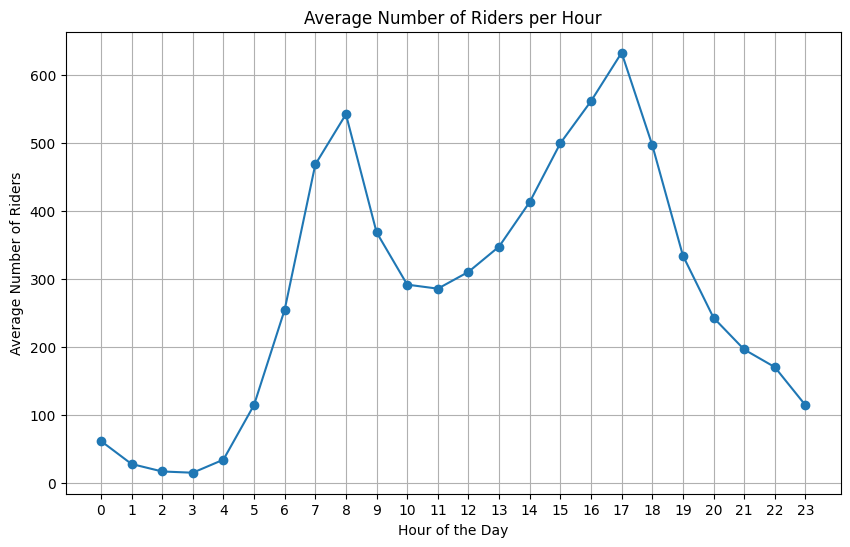

In [35]:
# Step 3: Extract the hour from 'transit_timestamp'
df['hour'] = df['transit_timestamp'].dt.hour

# Step 4: Calculate the average number of riders for each hour
average_riders_per_hour = df.groupby('hour')['ridership'].mean()

# Step 5: Plot the data on a graph
plt.figure(figsize=(10, 6))
plt.plot(average_riders_per_hour.index, average_riders_per_hour.values, marker='o', linestyle='-')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Riders')
plt.title('Average Number of Riders per Hour')
plt.xticks(average_riders_per_hour.index)
plt.grid(True)
plt.show()

#### Most popular stations
Popularity based by average ridership

In [36]:
top_10_stations = by_station_df.sort_values(by=['ridership'], ascending=False).head(10)

In [37]:
top_10_stations

,station_complex_id,station_complex,borough,latitude,longitude,ridership
134,N060,Times Sq-42 St,M,40.757310,-73.981964,45796626
303,R238,Grand Central-42 St,M,40.751778,-73.976845,24057336
4,A022,34 St-Herald Sq,M,40.749718,-73.987820,21372034
7,A034,14 St-Union Sq,M,40.735737,-73.989950,18401074
142,N095,Fulton St,M,40.710373,-74.006570,15329162
135,N070,34 St-Penn Station,M,40.752290,-73.993390,14845400
132,N049,59 St-Columbus Circle,M,40.768295,-73.981735,14073198
271,R135,34 St-Penn Station,M,40.750374,-73.991060,13891761
390,R533,Flushing-Main St,Q,40.759600,-73.830030,12100549
383,R525,74-Broadway,Q,40.746850,-73.891335,12022536


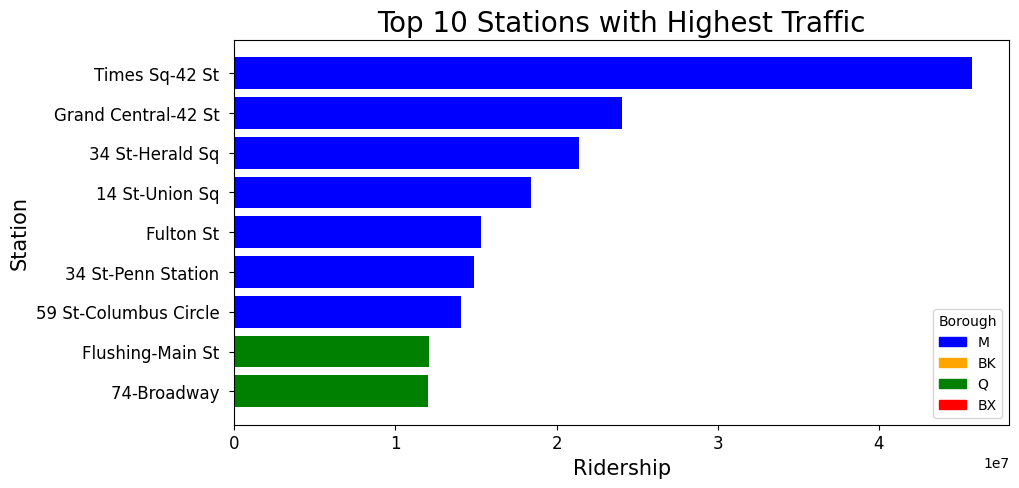

In [38]:
# Borough colors
borough_colors = {'M': 'blue', 'BK': 'orange', 'Q': 'green', 'BX': 'red'}

plt.figure(figsize=(10, 5))

# Plot each bar separately with the specified color
for i, station in enumerate(top_10_stations['station_complex']):
    plt.barh(station, top_10_stations['ridership'].iloc[i], color=borough_colors[top_10_stations['borough'].iloc[i]])

plt.title('Top 10 Stations with Highest Traffic', fontsize=20)
plt.xlabel('Ridership', fontsize=15)
plt.ylabel('Station', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()

# Create custom legend for borough colors
handles = [plt.Rectangle((0, 0), 1, 1, color=borough_colors[borough]) for borough in borough_colors]
labels = list(borough_colors.keys())
plt.legend(handles, labels, title='Borough')

plt.show()

#### How much usage do the top 10 stations account for?

In [39]:
## sum of all ridership in by_station_df
# by_station_df['total_ridership'] = by_station_df['ridership'].sum(axis=1)
total_ridership = by_station_df['ridership'].sum()
top_10_ridership = top_10_stations['ridership'].sum()

In [40]:
percentage_of_ridership_from_top10 = top_10_ridership / total_ridership * 100
print(f"Percentage of total ridership from the 10 most popular stations: {percentage_of_ridership_from_top10:.2f}%")

## get total number of rows in the dataframe
stations_total = len(by_station_df)
print(f"These 10 stations only account for {((10/stations_total)*100):.2f}% of the total number of stations")

Percentage of total ridership from the 10 most popular stations: 18.51%
These 10 stations only account for 2.36% of the total number of stations


____

### 4. Geographical Visualization 

Find the ridership per day

In [41]:
by_station_df['ridership_per_day'] = by_station_df['ridership'] / 365
# round ridership_per_day to a whole number
by_station_df['ridership_per_day'] = by_station_df['ridership_per_day'].round(0)

Connecting to Mapbox API with a public token

In [42]:
mapbox_token = 'pk.eyJ1Ijoibmlja2dlbnR6IiwiYSI6ImNsMnE4MXBqYTFodWozamt6Y3UzaDN2bm8ifQ.sudv6WDuPydt3LtqMLJZlw'

Setup markers and get the ridership per day

In [43]:
# new column called scaled_marker_size with a number that is a fraction of ridership_per_day
# this new column will be used to display a normalized marker size for ridership
by_station_df['scaled_marker_size'] = by_station_df['ridership_per_day'] / by_station_df['ridership_per_day'].max() * 75

# round scaled_marker-size to 4 decimal places
by_station_df['scaled_marker_size'] = by_station_df['scaled_marker_size'].round(4)

# new column called locked_marker_size with a value of 1
# this will lock the lowest marker size to 1
by_station_df['locked_marker_size'] = 1
by_station_df.head()

,station_complex_id,station_complex,borough,latitude,longitude,ridership,ridership_per_day,scaled_marker_size,locked_marker_size
0,A002,Lexington Av,M,40.762660,-73.967255,10082907,27624.0,16.5123,1
1,A006,5 Av-59 St,M,40.764812,-73.973350,3065515,8399.0,5.0205,1
2,A010,57 St-7 Av,M,40.764664,-73.980660,6579806,18027.0,10.7757,1
3,A013,49 St,M,40.759900,-73.984140,4772207,13075.0,7.8156,1
4,A022,34 St-Herald Sq,M,40.749718,-73.987820,21372034,58554.0,35.0008,1


Create bins for the ridership

In [44]:
bins = [161.55, 10000, 50000, 75000, 135546]
bin_labels = [
    'Low (161 - 10000)',
    'Medium (10,000 - 50,000)',
    'High (50,000 - 75,000)',
    'Very High (75,000+)'
]

# Create a dictionary to map bin labels to colors
bin_colors = {
    'Low (161 - 10000)': 'rgb(255, 195, 0)',
    'Medium (10,000 - 50,000)': 'rgb(255, 87, 51)',
    'High (50,000 - 75,000)': 'rgb(199, 0, 57)',
    'Very High (75,000+)': 'rgb(88, 24, 69)'
}
by_station_df['ridership_bin'] = pd.cut(by_station_df['ridership_per_day'], bins=bins, labels=bin_labels)


In [45]:
# reorder by_station_df to do the highest ridership_per_day to lowest ridership_per_day
by_station_df = by_station_df.sort_values(by=['ridership_per_day'], ascending=False)

by_station_df = by_station_df.reset_index(drop=True)

In [46]:
by_station_df.head()

,station_complex_id,station_complex,borough,latitude,longitude,ridership,ridership_per_day,scaled_marker_size,locked_marker_size,ridership_bin
0,N060,Times Sq-42 St,M,40.757310,-73.981964,45796626,125470.0,75.0000,1,"Very High (75,000+)"
1,R238,Grand Central-42 St,M,40.751778,-73.976845,24057336,65911.0,39.3985,1,"High (50,000 - 75,000)"
2,A022,34 St-Herald Sq,M,40.749718,-73.987820,21372034,58554.0,35.0008,1,"High (50,000 - 75,000)"
3,A034,14 St-Union Sq,M,40.735737,-73.989950,18401074,50414.0,30.1351,1,"High (50,000 - 75,000)"
4,N095,Fulton St,M,40.710373,-74.006570,15329162,41998.0,25.1044,1,"Medium (10,000 - 50,000)"


### Using a heatmap

The advantages of a heatmap are that it is easier to see the density of the ridership. The disadvantage is that it is harder to see the exact location of the stations. This map also clearly indicates where the gaps are in the subway system. If we see a high density of ridership for only one station, this could indicate that there is a need for more stations in that area.

In [58]:
import folium
from folium.plugins import HeatMap

# Set base map with folium
m_2 = folium.Map(location=[40.75, -73.9], tiles='cartodbpositron', zoom_start=11)

# Prepare data for heatmap (convert latitude and longitude to a list of points)
heat_data = [[point.xy[1][0], point.xy[0][0], ridership] for point, ridership in zip(geo_stations_df.geometry, geo_stations_df.ridership)]

# Create the HeatMap
HeatMap(
    data=heat_data,
    radius=15,
    blur=10,
).add_to(m_2)

# Display the map
m_2


We see a high density of traffic in the midtown area which correlates with our most popular stations.

### Create a dash app to visualize the ridership by station

In [48]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H4("Interactive Ridership by Station Map"),
    dcc.Checklist(
        id='marker-size-toggle',
        options=[
            {'label': 'Use scaled markers', 'value': 'scaled_marker_size'}
        ],
        value=[]
    ),
    dcc.Graph(id='scatter-plot'),
])

@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('marker-size-toggle', 'value')]
)
def update_marker_size(selected_values):
    use_scaled_marker_size = 'scaled_marker_size' in selected_values

    hover_data = ['ridership_per_day', 'ridership', 'station_complex']

    hover_template = (
        "<b>Station</b>: %{customdata[2]}<br>"
        "<b>Station Complex ID</b>: %{customdata[3]}<br>"
        "<b>Ridership (Daily)</b>: %{customdata[0]:,.0f}<br>"
        "<b>Ridership (Yearly)</b>: %{customdata[1]:,.0f}"
    )

    # Create the Plotly figure based on the selected option
    if use_scaled_marker_size:
        fig = px.scatter_mapbox(
            by_station_df,
            lat='latitude',
            lon='longitude',
            color='ridership_bin',
            hover_name='station_complex',
            custom_data=[
                by_station_df['ridership_per_day'],
                by_station_df['ridership'],
                by_station_df['station_complex'],
                by_station_df['station_complex_id']

            ],
            size='scaled_marker_size',
            color_discrete_map=bin_colors
        )
    else:
        fig = px.scatter_mapbox(
            by_station_df,
            lat='latitude',
            lon='longitude',
            color='ridership_bin',
            hover_name='station_complex',
            custom_data=[
                by_station_df['ridership_per_day'],
                by_station_df['ridership'],
                by_station_df['station_complex'],
                by_station_df['station_complex_id']
            ],
            color_discrete_map=bin_colors
        )

    # Set the Mapbox token and map style
    fig.update_layout(
        mapbox=dict(
            accesstoken=mapbox_token,
            style='mapbox://styles/mapbox/dark-v10',
            center=dict(lat=40.7128, lon=-74.0060),
            zoom=8.7,
        ),
        hovermode='closest',
    )

    fig.update_traces(hovertemplate=hover_template)

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


Toggle between scaled and standard markers to indicate the clear increase in ridership in midtown Manhattan. Times Square, Herald Square, Grand Central, and Penn Station all located in midtown and we see a large difference in traffic compared to other areas of Manhattan or other boroughs.

____

### 5. Predicting Ridership

If we can create a model to predict ridership at any given time, this would be an incredibly useful tool for the MTA to use. This would allow them to better plan for maintenance, staffing, and other resources. This data set is limited to only a few factors that could affect ridership, but it is a good starting point and will indicate if it is possible to create a model to predict ridership.

I chose to use Random Forest Regression for this task because we needed to choose a model that can handle non-linear data and it is not prone to overfitting.

In [49]:
# make a new dataframe called rfr_df
rfr_df = pd.DataFrame()

Prep the new dataframe

In [50]:
rfr_df['month'] = original_df['transit_timestamp'].dt.month
rfr_df['day'] = original_df['transit_timestamp'].dt.day
rfr_df['hour'] = original_df['transit_timestamp'].dt.hour
rfr_df['ridership'] = original_df['ridership']

rfr_df = rfr_df.groupby(['month', 'day', 'hour'])['ridership'].sum().reset_index()

rfr_df.head()


,month,day,hour,ridership
0,1,1,0,76113
1,1,1,1,70846
2,1,1,2,43543
3,1,1,3,23324
4,1,1,4,14958


In [51]:
X = rfr_df[['month', 'day', 'hour']]
y = rfr_df['ridership']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Mean Absolute Error: 31931.12 riders.
R-squared (R2): 0.88
Accuracy: 75.47 %.


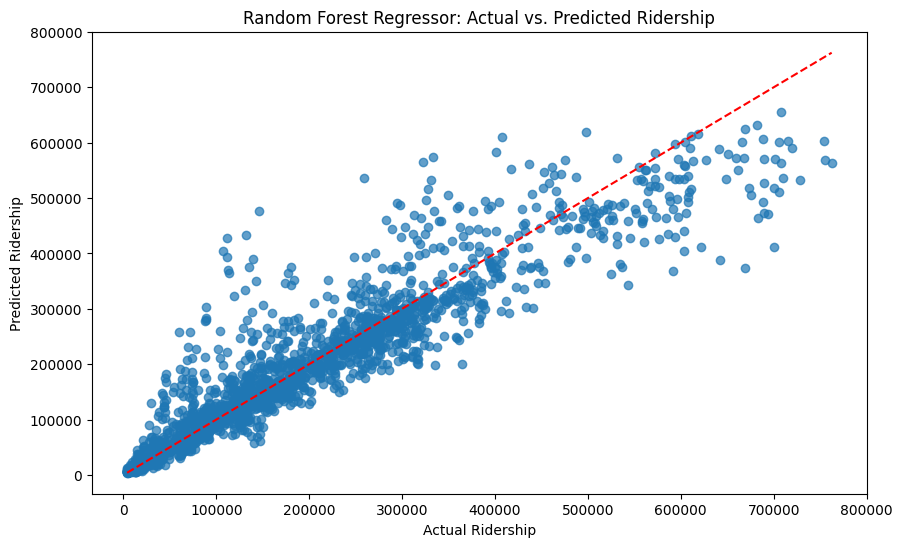

In [52]:
# Split the data into features and labels
labels = np.array(rfr_df['ridership'])
features = rfr_df.drop('ridership', axis=1)
feature_list = list(features.columns)
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.25, random_state=38
)

# Instantiate model with decision trees
rf = RandomForestRegressor(n_estimators=400, random_state=38)

# Train the model on training data
rf.fit(train_features, train_labels)

# Make predictions on the test set
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (MAE)
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', round(mae, 2), 'riders.')

# Calculate the R-squared (R2)
r2 = r2_score(test_labels, predictions)
print('R-squared (R2):', round(r2, 2))

# Calculate and display Mean Absolute Percentage Error (MAPE) and Accuracy
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# Create a scatter plot to visualize the predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, alpha=0.7)
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')

plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Random Forest Regressor: Actual vs. Predicted Ridership')
plt.show()


We can see we got an impressive R2 score of 0.88. This indicates that our model has potential to fit the data. This was only based on three factors. Unfortunately, the model has a mean absolute error of around 32 thousand. However if more factors were added to the model, it could potentially be improved, such as weather, unique stations, holidays, etc.

What are the most important features in our model?

month: 0.25222014283065824
day: 0.13287063052608278
hour: 0.6149092266432591


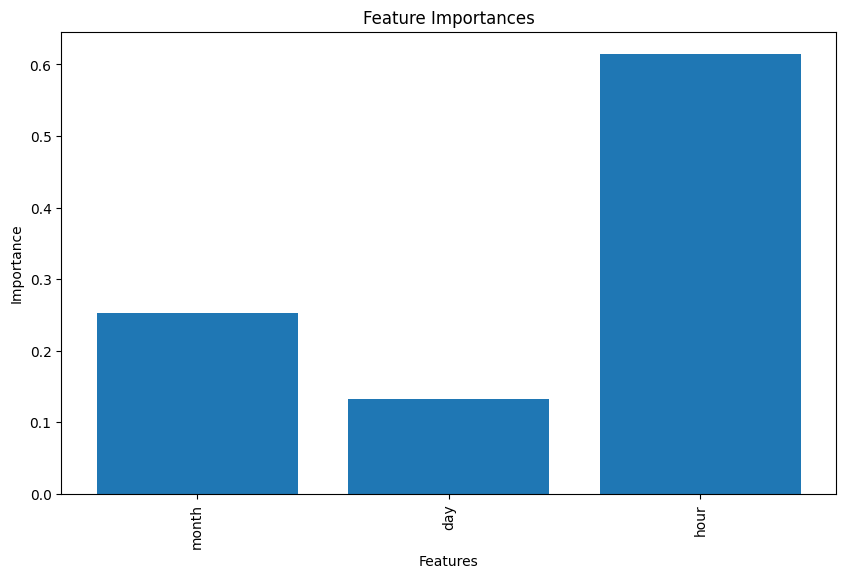

In [53]:
# Train the model on training data
rf.fit(train_features, train_labels)

# Get feature importances
feature_importances = rf.feature_importances_

# Associate feature importances with feature names
feature_importance_list = list(zip(feature_list, feature_importances))

# Print the top N most important features and their importances
for feature, importance in feature_importance_list:
    print(f"{feature}: {importance}")

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), [feature[0] for feature in feature_importance_list], rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()


The hour of day is a major indicator on the amount of ridership.

#### Function for predicting ridership

This function uses the model we created and predicts the ridership based on the inputted parameters which are month day and hour.

In [59]:
def predict_and_show_ridership(month, day, hour):
    input_data = np.array([[month, day, hour]])
    predicted_ridership = rf.predict(input_data)
    actual_ridership = rfr_df[(rfr_df['month'] == month) & (rfr_df['day'] == day) & (rfr_df['hour'] == hour)]['ridership'].values[0]
    
    print(f"Input: Month={month}, Day={day}, Hour={hour}")
    print(f"Predicted Ridership: {round(predicted_ridership[0], 2)}")
    print(f"Actual Ridership: {actual_ridership}")

In [63]:
# Test the function with a specific input
predict_and_show_ridership(month=5, day=5, hour=12)

Input: Month=5, Day=5, Hour=12
Predicted Ridership: 286930.37
Actual Ridership: 299513


In [64]:
predict_and_show_ridership(month=3, day=27, hour=2)

Input: Month=3, Day=27, Hour=2
Predicted Ridership: 15467.66
Actual Ridership: 15270


___

### 6. Conclusion

### This analysis has successfully shown that many of the potential goals of the analysis can be answered using data

#### -- Schedule maintenance and improve crowd management

This analysis shows we can easily determine the trends for which stations, time of day and day of the week have the most riders. This information can be used to schedule maintenance and improve crowd management. We did this through bar charts, strip plots, and treemaps.

#### -- Ridership by location

It is also clear that by using geovisualization and exploratory data analysis techniques, we can see which boroguhs and stations have the most riders. The heatmap and dash app are great tools to visualize this data.

#### -- Predicting Ridership

We were able to predict ridership with a **high degree of accuracy**. This shows that there is potential to build a model to predict ridership. I believe that given the right data, this model could be improved and reliably predict how many riders will be at a given station at a given time.